In [90]:
# imports
import os
os.sys.path.append(os.path.abspath(".."))

import tensorflow as tf

# import random

# from copy import deepcopy

import pandas as pd
import numpy as np
import h5py

# import keras

from matplotlib import pyplot as plt

# import json

# import notebooks_utils.analysis as utils
from notebooks_utils import visuals

# from IPython.display import display

import project.download_content as content
from project.utils import data
from project.model.loss import BBOX_REF

# METAPATH = os.path.join(content.DATAPATH, 'METADATA')


# from keras.applications import VGG19, VGG16
from keras.preprocessing import image
# from keras.applications.vgg19 import preprocess_input as preprocess_19
# from keras.applications.vgg16 import preprocess_input as preprocess_16
# from keras.models import Model

# from keras import backend as K
# from keras import layers
from keras.optimizers import Adam, SGD

# import swifter

from project.model.ssd_model_300 import ssd_model_300
from project.model.ssd_model_624 import ssd_model_624
from project.model.ssd_model_624_vgg_19 import ssd_model_624_vgg_19
from project.model.loss import SSDloss
# from project.model.iou import iou
# from project.model.smooth_l1 import smooth_l1

# from project.utils import data
datapath = os.path.join(content.DATAPATH, "MODEL", "part_data_300_vgg.h5")

anchors = BBOX_REF.references.values

In [94]:
anchors.shape

(8732, 4)

In [96]:
bboxes.shape

(6, 603)

In [117]:
blank_y = np.zeros((anchors.shape[0], bboxes.shape[1] + 1))
blank_y[:, 0] = 1
blank_y[1241]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## loading dataset

In [22]:
with h5py.File(datapath, 'r') as f:
    groups = list(f.keys())

# setting a group to exploration
group = groups[1]

In [23]:
with h5py.File(datapath, 'r') as f:
    images = f[group]['images'][:]
    
images

array([['43d87bf2ef8458e3', 'data/TRAIN/train_4/43d87bf2ef8458e3.jpg'],
       ['43dd9d71505ef57f', 'data/TRAIN/train_4/43dd9d71505ef57f.jpg'],
       ['43ddf01ef4611fc2', 'data/TRAIN/train_4/43ddf01ef4611fc2.jpg'],
       ...,
       ['8b7a92870892a682', 'data/TRAIN/train_8/8b7a92870892a682.jpg'],
       ['8b7b5266d4a88bcb', 'data/TRAIN/train_8/8b7b5266d4a88bcb.jpg'],
       ['8b7d78b15fce30b0', 'data/TRAIN/train_8/8b7d78b15fce30b0.jpg']],
      dtype=object)

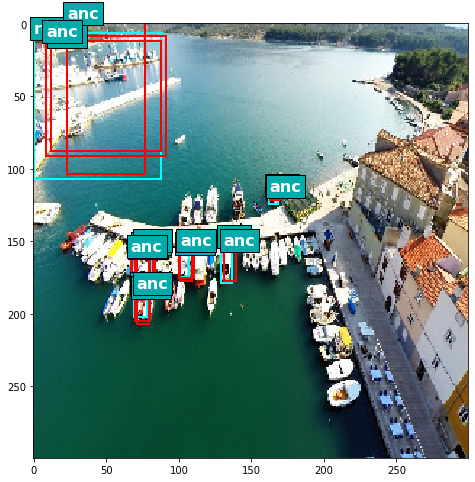

In [72]:
sample = images[205]

img = image.load_img(sample[1], target_size=(300, 300))

plt.figure(figsize=(12,8))
plt.imshow(img)
# plt.grid()
# plt.xticks(range(0, 301, int(300/75)))
# plt.yticks(range(0, 301, int(300/75)))

with h5py.File(datapath, 'r') as f:
    bboxes = f[group][sample[0]][:]
    refs = f[group][f"{sample[0]}-anchors"][:]
    
visuals.draw_many_bboxes(img, bboxes[:, -4:], label='ref')
for r in refs:
    visuals.draw_many_bboxes(img, anchors[r], label='anc', color="#ff0000")

In [88]:
x = np.concatenate([bboxes, np.expand_dims(refs, axis=-1)], axis=1)
x.shape

(6, 604)

In [92]:
for *labels, cx, cy, w, h in bboxes:
    print([cx, cy, w, h])

[0.550625, 0.399061, 0.02125, 0.032864]
[0.4434375, 0.548122, 0.025625, 0.096244]
[0.34625, 0.549296, 0.0225, 0.065728]
[0.2453125, 0.640845, 0.028125, 0.065728]
[0.14625, 0.189554, 0.2925, 0.336854]
[0.2528125, 0.548709, 0.033125, 0.048122]


## model

The model has 7 layers to draw the bounding_boxes, they were called as `number_bbs`

in each layer there are some types of bouding boxes, specified as follow:

|         | number of regions | size of filter in pixels | ratios w/h          | number of bounding boxes |
|---------|-------------------|--------------------------|---------------------|--------------------------|
| 1st_bbs | 5776              | 24px/24px                | [1, 1/2, 2]         | 17328                    |
| 2nd_bbs | 1369              | 48px/48px                | [1, 1/2, 2]         | 4107                     |
| 3rd_bbs | 289               | 98px/98px                | [1, 1/2, 1/3, 2, 3] | 1445                     |
| 4th_bbs | 49                | 208px/208px              | [1, 1/2, 1/3, 2, 3] | 245                      |
| 5th_bbs | 25                | 267px/267px              | [1, 1/2, 1/3, 2, 3] | 125                      |
| 6th_bbs | 9                 | 374px/374px              | [1, 1/2, 1/3, 2, 3] | 45                       |
| 7th_bbs | 1                 | 623px/624px              | [1, 1/2, 1/3, 2, 3] | 5                        |

In [5]:
model = ssd_model_300()

# sgd = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# ssd_loss = SSDloss()
# model.compile(optimizer=sgd, loss=ssd_loss.loss)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 300, 300, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 300, 300, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 150, 150, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

## Training

In [8]:
model.load_weights(content.DATAPATH + '/weights300vgg16.h5')

In [10]:
train.loc[131]

ImageID                                 360fbcecdf089b17
Path             data/TRAIN/train_3/360fbcecdf089b17.jpg
cx                                           [0.1928125]
cy                                           [0.4792165]
w                                             [0.215625]
h                                             [0.331735]
bbox_ref                            [[8696, 8697, 8699]]
LabelSemantic                               [skyscraper]
boat                                             [False]
land_vehicle                                     [False]
skyscraper                                        [True]
Name: 131, dtype: object

In [11]:
target[131, 8696]

array([0.    , 0.    , 0.    , 1.    , 0.1929, 0.4792, 0.2156, 0.3318],
      dtype=float16)

ImageID                                 360fbcecdf089b17
Path             data/TRAIN/train_3/360fbcecdf089b17.jpg
cx                                           [0.1928125]
cy                                           [0.4792165]
w                                             [0.215625]
h                                             [0.331735]
bbox_ref                            [[8696, 8697, 8699]]
LabelSemantic                               [skyscraper]
boat                                             [False]
land_vehicle                                     [False]
skyscraper                                        [True]
Name: 131, dtype: object

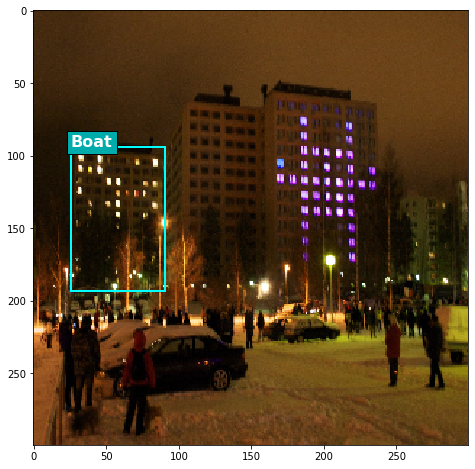

In [12]:
img_path = train.loc[131]

display(img_path)

img = image.load_img(img_path.Path, target_size=(300, 300))

plt.figure(figsize=(12,8))
plt.imshow(img)
# # plt.grid(color='red')
# plt.xticks(range(0, 301, int(300/5)))
# plt.yticks(range(0, 301, int(300/5)))

visuals.draw_many_bboxes(img,
                         np.array([img_path.cx, img_path.cy, img_path.w, img_path.h]).T,
                         label='Boat');

In [13]:
pred = model.predict(np.expand_dims(image.img_to_array(img), axis=0))[0]

m_value = 0 
best_i = 0

for ind, row in enumerate(pred):
    if row[3] > m_value:
        m_value = row[1]
        best_i = ind

display(pred[best_i])
best_i

array([ 0.5340119 ,  0.1591485 ,  0.22400202,  0.0828376 ,  0.5272887 ,
        0.50544786, -0.0254224 ,  0.80783165], dtype=float32)

8728

1

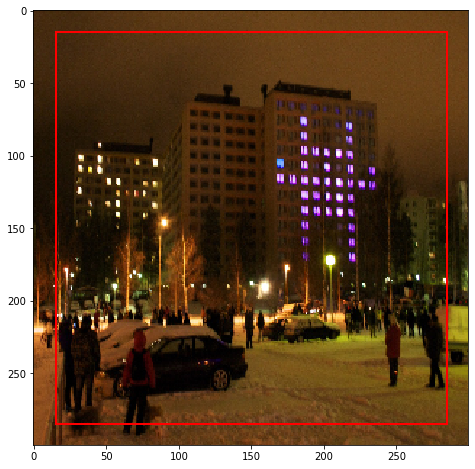

In [14]:
plt.figure(figsize=(12,8))
plt.imshow(img)

tt = 0

bis = []
for i, x in enumerate(pred):
    if i == best_i:
        tt += 1
        b = x
        bi = i
        bis.append(x)
        
        ref = standard_bboxes.references.iloc[bi]
        
        cx = pred[bi][-4]
        cy = pred[bi][-3]
        w = np.exp(pred[bi][-2])
        h = np.exp(pred[bi][-1])
        [cx, cy, w, h]
        
        visuals.draw_bbox(img, ref, color="#ff0000")
tt

1

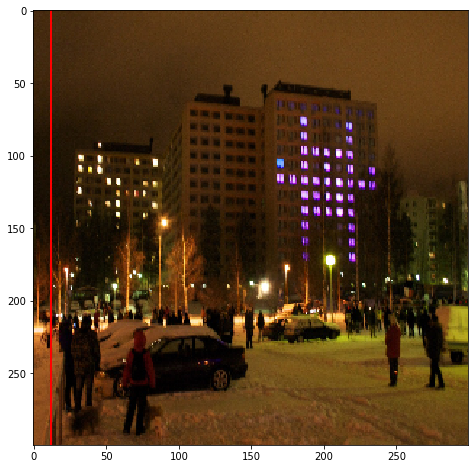

In [18]:
plt.figure(figsize=(12,8))
plt.imshow(img)

tt = 0

bis = []
for i, x in enumerate(pred):
    if i == best_i:
        tt += 1
        b = x
        bi = i
        bis.append(x)
        
        ref = standard_bboxes.references.iloc[bi]
        
        cx = pred[bi][-4]
        cy = pred[bi][-3]
        w = np.exp(pred[bi][-2])
        h = np.exp(pred[bi][-1])
        
        
        visuals.draw_bbox(img, [cx, cy, w, h], color="#ff0000")
tt

In [17]:
h

2.243039